## evenly

In [ ]:

from networkx import sigma
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.family'] = 'Times New Roman' 
plt.rcParams['axes.unicode_minus'] = False  
import nlopt
import scipy.stats as stats
from scipy.interpolate import UnivariateSpline

plt.rcParams.update({ 
    "font.size": 14,          
    "axes.labelsize": 16,      
    "xtick.labelsize": 14,     
    "ytick.labelsize": 14,    
    "legend.fontsize": 12      
})
import sys 
sys.path.append("..")
from function0428 import *
from tqdm import tqdm

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


/home/lab422/422File/Class_2023/zt/2025/Adaptivedesign10/Z_equl


In [ ]:
# 初始化预测器 
predictor = TsPredictor()

Compiling model...
'compile' took 0.316005 s

Restoring model from /home/lab422/422File/Class_2023/zt/2025/Adaptivedesign10/Z_equl/models1008/mionet_model.ckpt-76000.pt ...



In [ ]:

sigma = 2 #/10    
mu1_true=0.0858
mu2_true=0.9142
alpha_true=10.41



tmax=180
tt=np.linspace(0,tmax,11)


pred_params = [mu1_true, mu2_true, alpha_true]
TT = predictor.Tt(pred_params,  tt)

np.random.seed(42)

T_obs=TT+np.random.normal(0, sigma, TT.shape)# <class 'numpy.ndarray'>

print("T_obs",T_obs)

data = T_obs


T_obs [293.64555843 301.16823458 309.43450671 315.61560927 315.57960585
 318.62199708 324.56336338 324.44905403 323.22392354 325.97016037
 324.38712946]


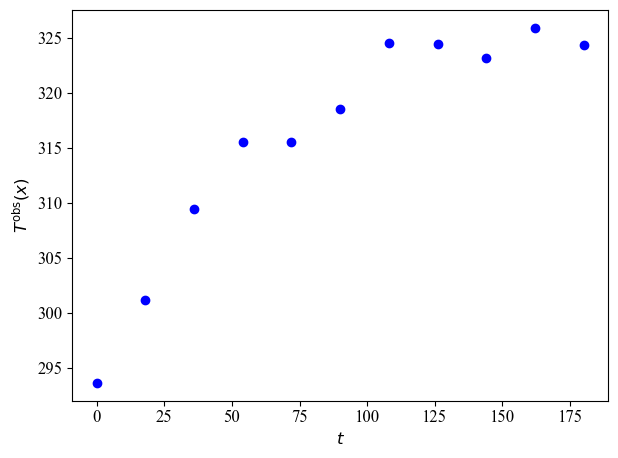

In [ ]:

fig1, ax1 = plt.subplots()
ax1.scatter(tt, data, color='blue')  # scatter(t,data,mc=:blue,msc=:match,label=false)
ax1.plot([], [])  # create an empty plot handle for further additions
ax1.set_xlabel(r"$t$")
ax1.set_ylabel(r'$T^{\mathrm{obs}}(x)$')
plt.tight_layout()


In [ ]:
a = np.zeros(3)  # Vector of unknown parameter values (mu2, alpha, log_sigma)
def loglhood(data, tt, a):
    # a = [mu2, alpha, log_sigma]
    mu2, alpha, log_sigma = a[0], a[1], a[2]
    sigma = np.exp(log_sigma)  
    y = predictor.Tt([0.0858, mu2, alpha], tt)
    dist = stats.norm(loc=0, scale=sigma)
    e = dist.logpdf(data - y)
    return np.sum(e)

def Optimise(fun, θ0, lb, ub):
    def tomax(θ, grad):
        return fun(np.array(θ))
    opt = nlopt.opt(nlopt.LN_NELDERMEAD, len(θ0))
    opt.set_max_objective(tomax)
    opt.set_lower_bounds(lb)
    opt.set_upper_bounds(ub)
    opt.set_maxtime(10*60)  
    opt.set_ftol_rel(1e-8)  
    opt.set_xtol_rel(1e-8)
    xopt = opt.optimize(θ0)
    fopt = opt.last_optimum_value()
    result_code = opt.last_optimize_result()
    

    if result_code < 0:
        print(f"Warning: Optimization failed with code {result_code}")
    
    return (xopt, fopt)

In [ ]:
def funmle(a):
    # function to optimize for the MLE, this function returns the log-likelihood for the vector of parameters a = (mu2, alpha, log_sigma)
    return loglhood(data, tt, a)

mu2min = 0.01; mu2max = 2; 
alphamin=1.;alphamax=30
sigmamin=0.01; sigmamax=6

θG = [0.9142, 10.41, np.log(2.0)]  # 初始参数 (mu2, alpha, log_sigma)
lb = [mu2min, alphamin, np.log(sigmamin)]
ub = [mu2max, alphamax, np.log(sigmamax)]
(xopt, fopt) = Optimise(funmle, θG, lb, ub)  # Call to NLopt

mu2mle = xopt[0]   # Store the MLE
alphamle = xopt[1]
sigmamle = np.exp(xopt[2])  

fmle = fopt      # Store the log-likelihood at the MLE
print(f"MLE parameters: mu2={mu2mle}, alpha={alphamle}, sigma={sigmamle}")
print(f"Log-likelihood at MLE: {fmle}")

MLE parameters: mu2=0.8474560676067769, alpha=13.724921045404088, sigma=1.3991619700410063
Log-likelihood at MLE: -19.295759604052176


Tmle_vals= [292.89526367 302.22357178 309.27398682 313.71536255 317.1149292
 319.90393066 322.00872803 323.34857178 324.5463562  325.30200195
 325.89035034]
Estimated sigma: 1.3991619700410063


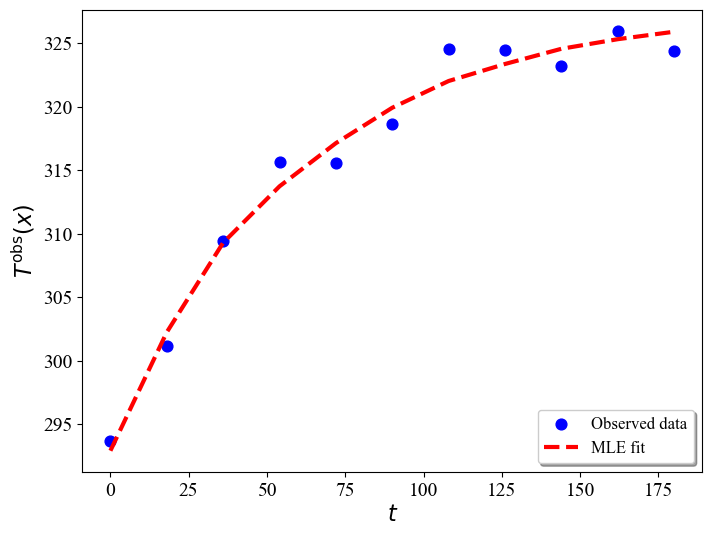

In [7]:
Tmle_vals = predictor.Tt([0.0858, mu2mle, alphamle], tt)
print("Tmle_vals=", Tmle_vals)
print(f"Estimated sigma: {sigmamle}")
fig2, ax2 = plt.subplots(figsize=(8, 6))
ax2.scatter(tt, data, color='blue', s=60, label='Observed data')
ax2.plot(tt, Tmle_vals, linewidth=3, color='red', linestyle='--', label='MLE fit')
ax2.legend(fontsize=12, frameon=True, shadow=True, loc='lower right')
ax2.set_xlabel(r"$t$", fontsize=16)
ax2.set_ylabel(r'$T^{\mathrm{obs}}(x)$', fontsize=16)
ax2.tick_params(labelsize=14)
fig2.canvas.draw()
plt.show()

In [8]:
df = 1  # degrees of freedom for the asymptotic threshold value for the univariate profile likelihood
llstar = -stats.chi2.ppf(0.95, df) / 2  # log-likelihood threshold for the 95% threshold
M=50
def univariatemu2(mu2):
    def funk(a):
        alpha, log_sigma = a[0], a[1]
        return loglhood(data, tt, np.array([mu2, alpha, log_sigma]))
    θG_inner = [alphamle, np.log(sigmamle)]
    lb_inner = [alphamin, np.log(sigmamin)]
    ub_inner = [alphamax, np.log(sigmamax)]
    (xopt_inner, fopt_inner) = Optimise(funk, θG_inner, lb_inner, ub_inner)
    return fopt_inner, xopt_inner
mu2range = np.linspace(mu2min, mu2max, M)
ff_mu2 = np.zeros(M)

for i in tqdm(range(M), desc="Processing"):
    ff_mu2[i] = univariatemu2(mu2range[i])[0]

Processing: 100%|██████████| 50/50 [00:50<00:00,  1.02s/it]


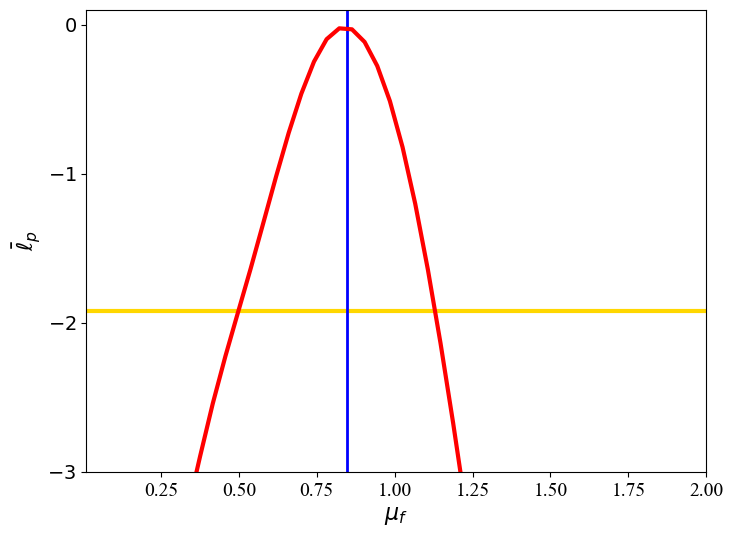

In [9]:

fig4, ax4 = plt.subplots(figsize=(8, 6))
ax4.axhline(y=llstar, linewidth=3, color='gold')  # Plot horizontal line for k profile likelihood
ax4.axvline(x=mu2mle, linewidth=2, color='blue')  # Plot vertical line at MLE k
# 统一使用 ff_mu2 - fmle 计算剖面似然
sp3 = UnivariateSpline(mu2range, ff_mu2 - fmle, k=3, w=np.ones(len(mu2range)), s=1/100)
yy_mu2 = sp3(mu2range)
ax4.plot(mu2range, yy_mu2, linewidth=3, color='red')
ax4.set_ylim(-3, 0.1)  # 设置 y 轴范围 
ax4.set_xlim(mu2range[0], mu2range[-1])  # 设置 x 轴范围 

ax4.set_yticks([0, -1, -2, -3])
ax4.set_yticklabels([r"$0$", r"$-1$", r"$-2$", r"$-3$"], fontsize=14)
ax4.set_xlabel(r"${\mu}_f$", fontsize=16)
ax4.set_ylabel(r"$\bar{\ell}_p$", fontsize=16)
ax4.tick_params(labelsize=14)
plt.draw()
plt.pause(0.001)


In [10]:
#print("",ff_mu2)
#print("",ff_mu2 - np.max(ff_mu2))

In [11]:
def univariatealpha(alpha):
    def funk(a):
        mu2, log_sigma = a[0], a[1]
        return loglhood(data, tt, np.array([mu2, alpha, log_sigma]))
    θG_inner = [mu2mle, np.log(sigmamle)]
    lb_inner = [mu2min, np.log(sigmamin)]
    ub_inner = [mu2max, np.log(sigmamax)]
    (xopt_inner, fopt_inner) = Optimise(funk, θG_inner, lb_inner, ub_inner)
    return fopt_inner, xopt_inner
def f_k(x):
    return univariatealpha(x)[0]
alpharange = np.linspace(alphamin, alphamax, M)
ff_alpha = np.zeros(M)
for i in tqdm(range(M), desc="Processing"):
    ff_alpha[i] = univariatealpha(alpharange[i])[0]

Processing: 100%|██████████| 50/50 [01:10<00:00,  1.40s/it]


In [12]:
df = 1  # degrees of freedom for the asymptotic threshold value for the univariate profile likelihood
llstar = -stats.chi2.ppf(0.95, df) / 2 
print("",llstar)

 -1.920729410347062


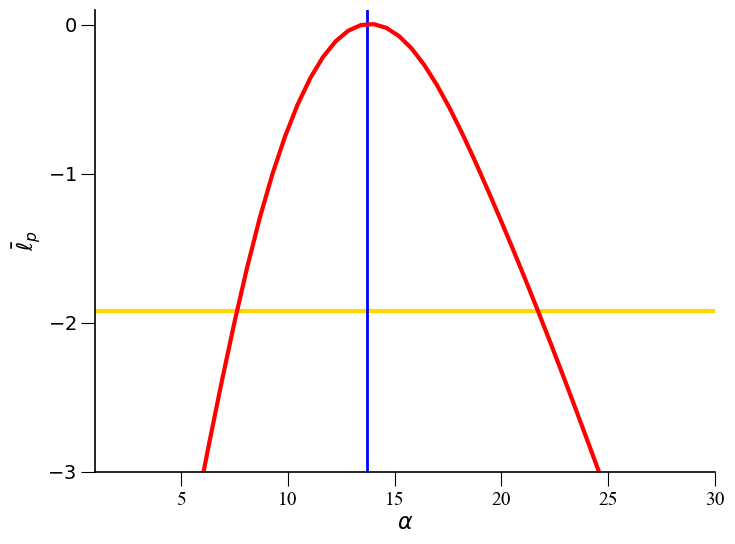

In [ ]:

fig5, ax5 = plt.subplots(figsize=(8, 6))
ax5.axhline(y=llstar, linewidth=3, color='gold')  # Plot horizontal line for k profile likelihood
ax5.axvline(x=alphamle, linewidth=2, color='blue')  # Plot vertical line at MLE k
# 统一使用 ff_alpha - fmle 计算剖面似然
sp3 = UnivariateSpline(alpharange, ff_alpha - fmle, k=3, w=np.ones(len(alpharange)), s=1/100)
yy_alpha = sp3(alpharange)
ax5.plot(alpharange, yy_alpha, linewidth=3, color='red')
ax5.set_ylim(-3, 0.1)  
ax5.set_xlim(alpharange[0], alpharange[-1]) 

ax5.set_yticks([0, -1, -2, -3])
ax5.set_yticklabels([r"$0$", r"$-1$", r"$-2$", r"$-3$"], fontsize=14)
ax5.set_xlabel(r"${\alpha}$", fontsize=16)
ax5.set_ylabel(r"$\bar{\ell}_p$", fontsize=16)
ax5.tick_params(labelsize=14)
plt.draw()
plt.pause(0.001)


In [ ]:

def univariatesigma(sigma):
    def funk(a):
        mu2, alpha = a[0], a[1]
        return loglhood(data, tt, np.array([mu2, alpha, np.log(sigma)]))
    θG_inner = [mu2mle, alphamle]
    lb_inner = [mu2min, alphamin]
    ub_inner = [mu2max, alphamax]
    (xopt_inner, fopt_inner) = Optimise(funk, θG_inner, lb_inner, ub_inner)
    return fopt_inner, xopt_inner

sigmarange = np.linspace(sigmamin, sigmamax, M)
ff_sigma = np.zeros(M)
for i in tqdm(range(M), desc="Processing sigma profile"):
    ff_sigma[i] = univariatesigma(sigmarange[i])[0]

Processing sigma profile: 100%|██████████| 50/50 [00:58<00:00,  1.18s/it]


σ的95%置信区间下界: 0.9740
σ的95%置信区间上界: 2.2709
σ的置信区间长度: 1.2969


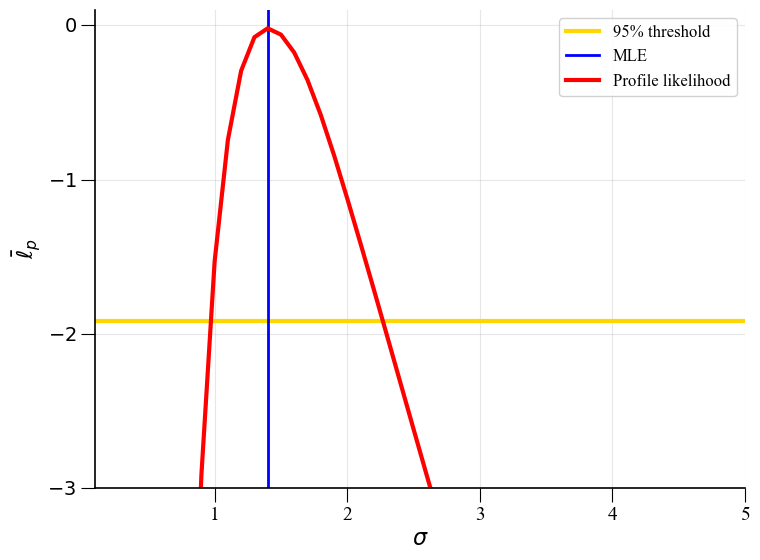

In [24]:
def interp_zero(x, y):
    zs = []
    n = len(x)
    for i in range(n - 1):
        x1, x2 = x[i], x[i + 1]
        y1, y2 = y[i], y[i + 1]
        if np.sign(y1) != np.sign(y2):
            m = (y2 - y1) / (x2 - x1)
            z = x1 - y1 / m
            zs.append(z)
    return zs
# sigma的置信区间计算
ratio_sigma = ff_sigma - fmle
y_sigma = ratio_sigma - llstar

# 找到交点
intersections_sigma = interp_zero(sigmarange, y_sigma)

# 解释结果
if len(intersections_sigma) == 2:
    sigma_min_ci = min(intersections_sigma)
    sigma_max_ci = max(intersections_sigma)
    sigma_ci_length = sigma_max_ci - sigma_min_ci
    print(f"σ的95%置信区间下界: {sigma_min_ci:.4f}")
    print(f"σ的95%置信区间上界: {sigma_max_ci:.4f}")
    print(f"σ的置信区间长度: {sigma_ci_length:.4f}")
else:
    print(f"预期找到2个交点，但实际找到了 {len(intersections_sigma)} 个")
    print("请检查sigmarange的范围或ff_sigma的计算。")

# sigma的剖面似然图
fig_sigma, ax_sigma = plt.subplots(figsize=(8, 6))
ax_sigma.axhline(y=llstar, linewidth=3, color='gold', label='95% threshold')
ax_sigma.axvline(x=sigmamle, linewidth=2, color='blue', label='MLE')
# 统一使用 ff_sigma - fmle 计算剖面似然
sp_sigma = UnivariateSpline(sigmarange, ff_sigma - fmle, k=3, w=np.ones(len(sigmarange)), s=1/100)
yy_sigma = sp_sigma(sigmarange)
ax_sigma.plot(sigmarange, yy_sigma, linewidth=3, color='red', label='Profile likelihood')
ax_sigma.set_ylim(-3, 0.1)
ax_sigma.set_xlim(sigmarange[0], sigmarange[-1])
ax_sigma.set_yticks([0, -1, -2, -3])
ax_sigma.set_yticklabels([r"$0$", r"$-1$", r"$-2$", r"$-3$"], fontsize=14)
ax_sigma.set_xlabel(r"$\sigma$", fontsize=16)
ax_sigma.set_ylabel(r"$\bar{\ell}_p$", fontsize=16)
ax_sigma.tick_params(labelsize=14)
ax_sigma.legend(fontsize=12, frameon=True)
ax_sigma.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [15]:
# Define interp_zero function
def interp_zero(x, y):
    zs = []
    n = len(x)
    for i in range(n - 1):
        x1, x2 = x[i], x[i + 1]
        y1, y2 = y[i], y[i + 1]
        if np.sign(y1) != np.sign(y2):
            m = (y2 - y1) / (x2 - x1)
            z = x1 - y1 / m
            zs.append(z)
    return zs

# Calculate log-likelihood ratio and difference from threshold
ratio = ff_mu2 - fmle
y = ratio - llstar

# Find intersection points
intersections = interp_zero(mu2range, y)

# Interpret results
if len(intersections) == 2:
    mu2_min_ci = min(intersections)
    mu2_max_ci = max(intersections)
    mu2_ci_length = mu2_max_ci - mu2_min_ci
    print(f"95% Confidence Interval Lower Bound: {mu2_min_ci:.4f}")
    print(f"95% Confidence Interval Upper Bound: {mu2_max_ci:.4f}")
    print(f"Confidence Interval Length: {mu2_ci_length:.4f}")
else:
    print("Expected 2 intersections, but found", len(intersections))
    print("Check mu1range span or ff_mu1 computation.")

95% Confidence Interval Lower Bound: 0.4962
95% Confidence Interval Upper Bound: 1.1291
Confidence Interval Length: 0.6329


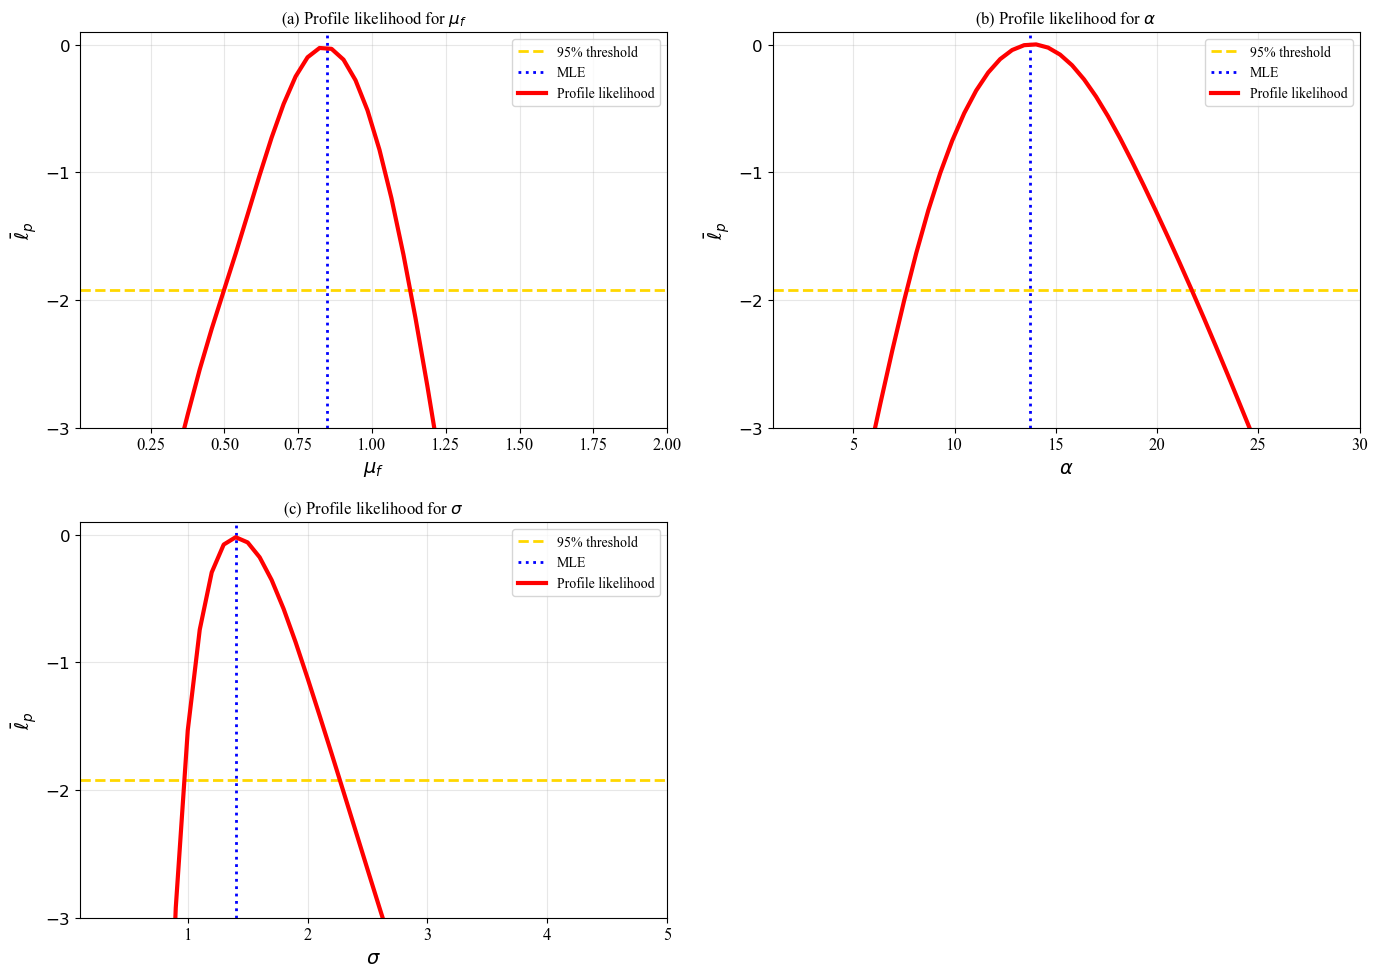

In [ ]:
# 1. 
fig_combined_all, axes = plt.subplots(2, 2, figsize=(14, 10))

# μ_f 
ax_mu2 = axes[0, 0]
ax_mu2.axhline(y=llstar, linewidth=2, color='gold', label='95% threshold', linestyle='--')
ax_mu2.axvline(x=mu2mle, linewidth=2, color='blue', label='MLE', linestyle=':')
sp3_mu2 = UnivariateSpline(mu2range, ff_mu2 - fmle, k=3, w=np.ones(len(mu2range)), s=1/100)
yy_mu2 = sp3_mu2(mu2range)
ax_mu2.plot(mu2range, yy_mu2, linewidth=3, color='red', label='Profile likelihood')
ax_mu2.set_ylim(-3, 0.1)
ax_mu2.set_xlim(mu2range[0], mu2range[-1])
ax_mu2.set_yticks([0, -1, -2, -3])
ax_mu2.set_yticklabels([r"$0$", r"$-1$", r"$-2$", r"$-3$"])
ax_mu2.set_xlabel(r"$\mu_f$", fontsize=14)
ax_mu2.set_ylabel(r"$\bar{\ell}_p$", fontsize=14)
ax_mu2.legend(fontsize=10, frameon=True)
ax_mu2.grid(True, alpha=0.3)
ax_mu2.set_title(r"(a) Profile likelihood for $\mu_f$", fontsize=12)

# α
ax_alpha = axes[0, 1]
ax_alpha.axhline(y=llstar, linewidth=2, color='gold', label='95% threshold', linestyle='--')
ax_alpha.axvline(x=alphamle, linewidth=2, color='blue', label='MLE', linestyle=':')
sp3_alpha = UnivariateSpline(alpharange, ff_alpha - fmle, k=3, w=np.ones(len(alpharange)), s=1/100)
yy_alpha = sp3_alpha(alpharange)
ax_alpha.plot(alpharange, yy_alpha, linewidth=3, color='red', label='Profile likelihood')
ax_alpha.set_ylim(-3, 0.1)
ax_alpha.set_xlim(alpharange[0], alpharange[-1])
ax_alpha.set_yticks([0, -1, -2, -3])
ax_alpha.set_yticklabels([r"$0$", r"$-1$", r"$-2$", r"$-3$"])
ax_alpha.set_xlabel(r"$\alpha$", fontsize=14)
ax_alpha.set_ylabel(r"$\bar{\ell}_p$", fontsize=14)
ax_alpha.legend(fontsize=10, frameon=True)
ax_alpha.grid(True, alpha=0.3)
ax_alpha.set_title(r"(b) Profile likelihood for $\alpha$", fontsize=12)

# σ 
ax_sigma = axes[1, 0]
ax_sigma.axhline(y=llstar, linewidth=2, color='gold', label='95% threshold', linestyle='--')
ax_sigma.axvline(x=sigmamle, linewidth=2, color='blue', label='MLE', linestyle=':')
sp3_sigma = UnivariateSpline(sigmarange, ff_sigma - fmle, k=3, w=np.ones(len(sigmarange)), s=1/100)
yy_sigma = sp3_sigma(sigmarange)
ax_sigma.plot(sigmarange, yy_sigma, linewidth=3, color='red', label='Profile likelihood')
ax_sigma.set_ylim(-3, 0.1)
ax_sigma.set_xlim(sigmarange[0], sigmarange[-1])
ax_sigma.set_yticks([0, -1, -2, -3])
ax_sigma.set_yticklabels([r"$0$", r"$-1$", r"$-2$", r"$-3$"])
ax_sigma.set_xlabel(r"$\sigma$", fontsize=14)
ax_sigma.set_ylabel(r"$\bar{\ell}_p$", fontsize=14)
ax_sigma.legend(fontsize=10, frameon=True)
ax_sigma.grid(True, alpha=0.3)
ax_sigma.set_title(r"(c) Profile likelihood for $\sigma$", fontsize=12)

# 隐藏右下角的子图
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

In [17]:
# Calculate log-likelihood ratio and difference from threshold
ratio2 = ff_alpha - fmle
y = ratio2 - llstar

# Find intersection points
intersections = interp_zero(alpharange, y)

# Interpret results
if len(intersections) == 2:
    alpha_min_ci = min(intersections)
    alpha_max_ci = max(intersections)
    alpha_ci_length = alpha_max_ci - alpha_min_ci
    print(f"95% Confidence Interval Lower Bound: {alpha_min_ci:.4f}")
    print(f"95% Confidence Interval Upper Bound: {alpha_max_ci:.4f}")
    print(f"Confidence Interval Length: {alpha_ci_length:.4f}")
else:
    print("Expected 2 intersections, but found", len(intersections))
    print("Check mu1range span or ff_mu1 computation.")

95% Confidence Interval Lower Bound: 7.6901
95% Confidence Interval Upper Bound: 21.7248
Confidence Interval Length: 14.0348


In [ ]:
t_obs = tt
df = 2  # degrees of freedom for the asymptotic threshold value
llstar = -stats.chi2.ppf(0.95, df) / 2  # log-likelihood threshold for the 95% threshold

M2 = 100  # Number of samples to be drawn
mu2sampled = np.zeros(M2)
alphasampled = np.zeros(M2)
sigmasampled = np.zeros(M2)
lls = np.zeros(M2)
kount = 0

mu2min2 = mu2min; mu2max2 = mu2max  
alphamin2 = alphamin; alphamax2 = alphamax  
sigmamin2 = sigmamin; sigmamax2 = sigmamax  
# 初始化进度条 
pbar = tqdm(total=M2, desc="Sampling MCMC Chains", dynamic_ncols=True)
while kount < M2:
    mu2g = np.random.uniform(mu2min2, mu2max2)
    alphag = np.random.uniform(alphamin2, alphamax2)
    sigmag = np.random.uniform(sigmamin2, sigmamax2)

    llhf = loglhood(data, t_obs, np.array([mu2g, alphag, np.log(sigmag)])) - fmle 
    if llhf >= llstar:
        kount += 1 
        lls[kount-1] = llhf 
        mu2sampled[kount-1] = mu2g 
        alphasampled[kount-1] = alphag 
        sigmasampled[kount-1] = sigmag 
        pbar.update(1)   # 更新进度 
        pbar.set_postfix({"Current μ2": f"{mu2g:.4f}", "α": f"{alphag:.4f}", "σ": f"{sigmag:.4f}"})  # 可选参数显示 
pbar.close()

Sampling MCMC Chains: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s, Current μ2=0.9874, α=13.1579, σ=1.5270]


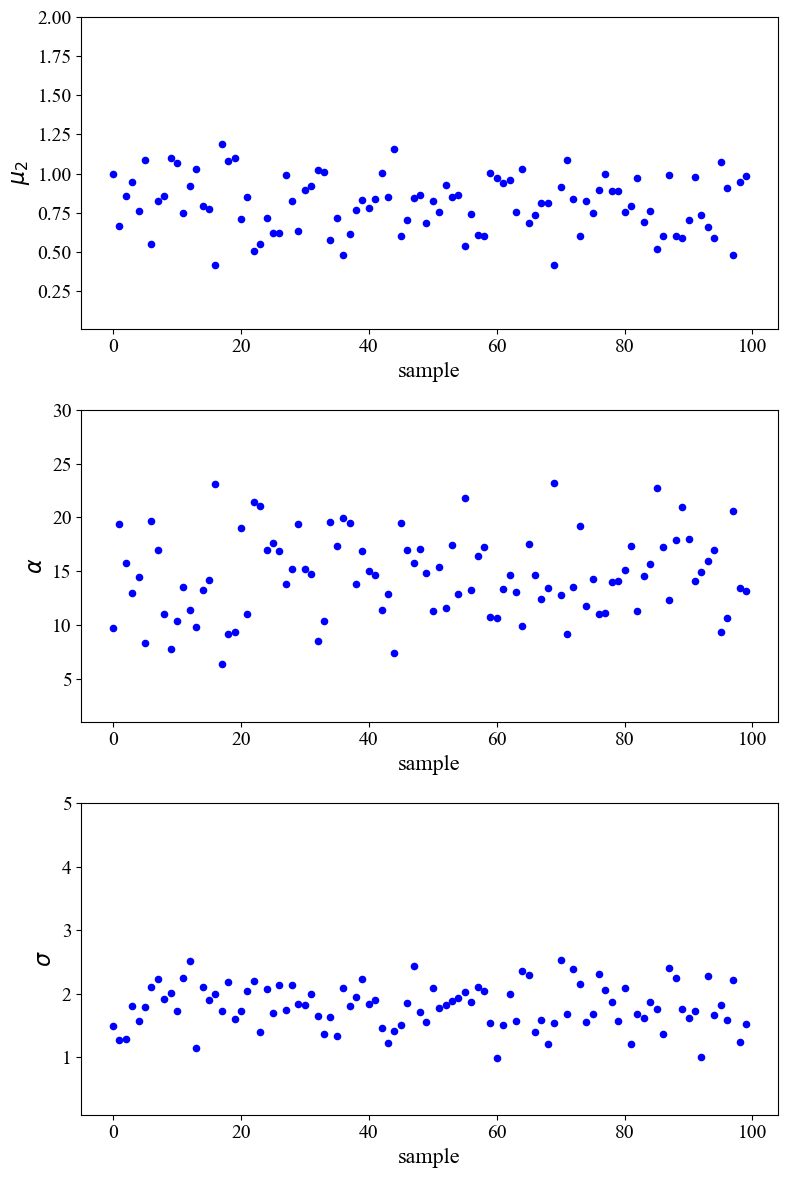

In [19]:
# a1: plot samples of mu2
fig8, (ax8_top, ax8_mid, ax8_bot) = plt.subplots(3, 1, figsize=(8, 12))
ax8_top.scatter(range(M2), mu2sampled, color='blue', s=20)
ax8_top.set_xlabel("sample", fontsize=16)
ax8_top.set_ylabel(r"${\mu}_2$", fontsize=16)
ax8_top.set_ylim(mu2min, mu2max)
ax8_top.tick_params(labelsize=14)
# a2: plot samples of alpha
ax8_mid.scatter(range(M2), alphasampled, color='blue', s=20)
ax8_mid.set_xlabel("sample", fontsize=16)
ax8_mid.set_ylabel(r"${\alpha}$", fontsize=16)
ax8_mid.set_ylim(alphamin, alphamax)
ax8_mid.tick_params(labelsize=14)
# a3: plot samples of sigma
ax8_bot.scatter(range(M2), sigmasampled, color='blue', s=20)
ax8_bot.set_xlabel("sample", fontsize=16)
ax8_bot.set_ylabel(r"$\sigma$", fontsize=16)
ax8_bot.set_ylim(sigmamin, sigmamax)
ax8_bot.tick_params(labelsize=14)
plt.tight_layout()
plt.draw()
plt.pause(0.001)
plt.show(block=False)

Computing smooth prediction intervals: 100%|██████████| 100/100 [00:01<00:00, 70.54it/s]


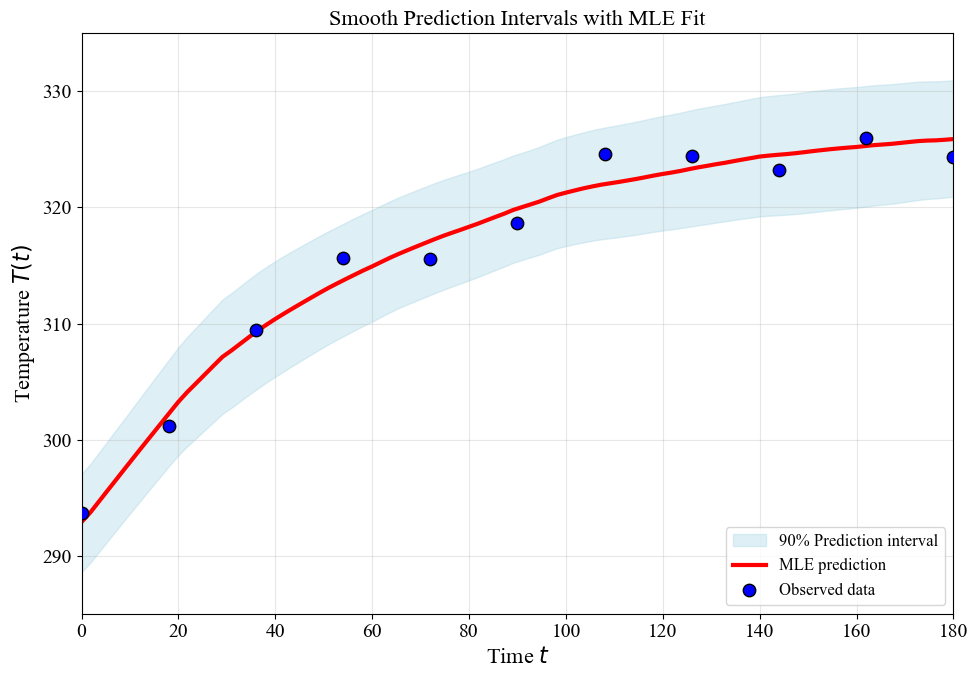

In [ ]:
# 2. 
# 
t_fine = np.linspace(0, tmax, 100)  # 
lower_fine = np.full(len(t_fine), 1000)  # 
upper_fine = np.zeros(len(t_fine))       # 

# 
for i in tqdm(range(M2), desc="Computing smooth prediction intervals", position=0, colour='green'):
    # 
    pred_vals = predictor.Tt([0.0858, mu2sampled[i], alphasampled[i]], t_fine)
    
    # 
    q_low = stats.norm.ppf(0.05, loc=0, scale=sigmasampled[i])
    q_high = stats.norm.ppf(0.95, loc=0, scale=sigmasampled[i])
    
    # 
    pred_low = pred_vals + q_low
    pred_high = pred_vals + q_high
    
    # 
    lower_fine = np.minimum(lower_fine, pred_low)
    upper_fine = np.maximum(upper_fine, pred_high)

fig9_smooth, ax9_smooth = plt.subplots(figsize=(10, 7))
ax9_smooth.fill_between(t_fine, lower_fine, upper_fine, color='lightblue', alpha=0.4, label='90% Prediction interval')
mle_prediction_fine = predictor.Tt([0.0858, mu2mle, alphamle], t_fine)
ax9_smooth.plot(t_fine, mle_prediction_fine, linewidth=3, color='red', label='MLE prediction', linestyle='-')
ax9_smooth.scatter(t_obs, data, color='blue', s=80, zorder=5, label='Observed data', edgecolors='black', linewidth=1)
ax9_smooth.set_xlabel(r"Time $t$", fontsize=16)
ax9_smooth.set_ylabel(r"Temperature $T(t)$", fontsize=16)
ax9_smooth.set_xlim(0, tmax)
ax9_smooth.set_ylim(285, 335)
ax9_smooth.legend(fontsize=12, frameon=True, loc='lower right')
ax9_smooth.tick_params(labelsize=14)
ax9_smooth.grid(True, alpha=0.3)
ax9_smooth.set_title("Smooth Prediction Intervals with MLE Fit", fontsize=16)
plt.tight_layout()
plt.show()

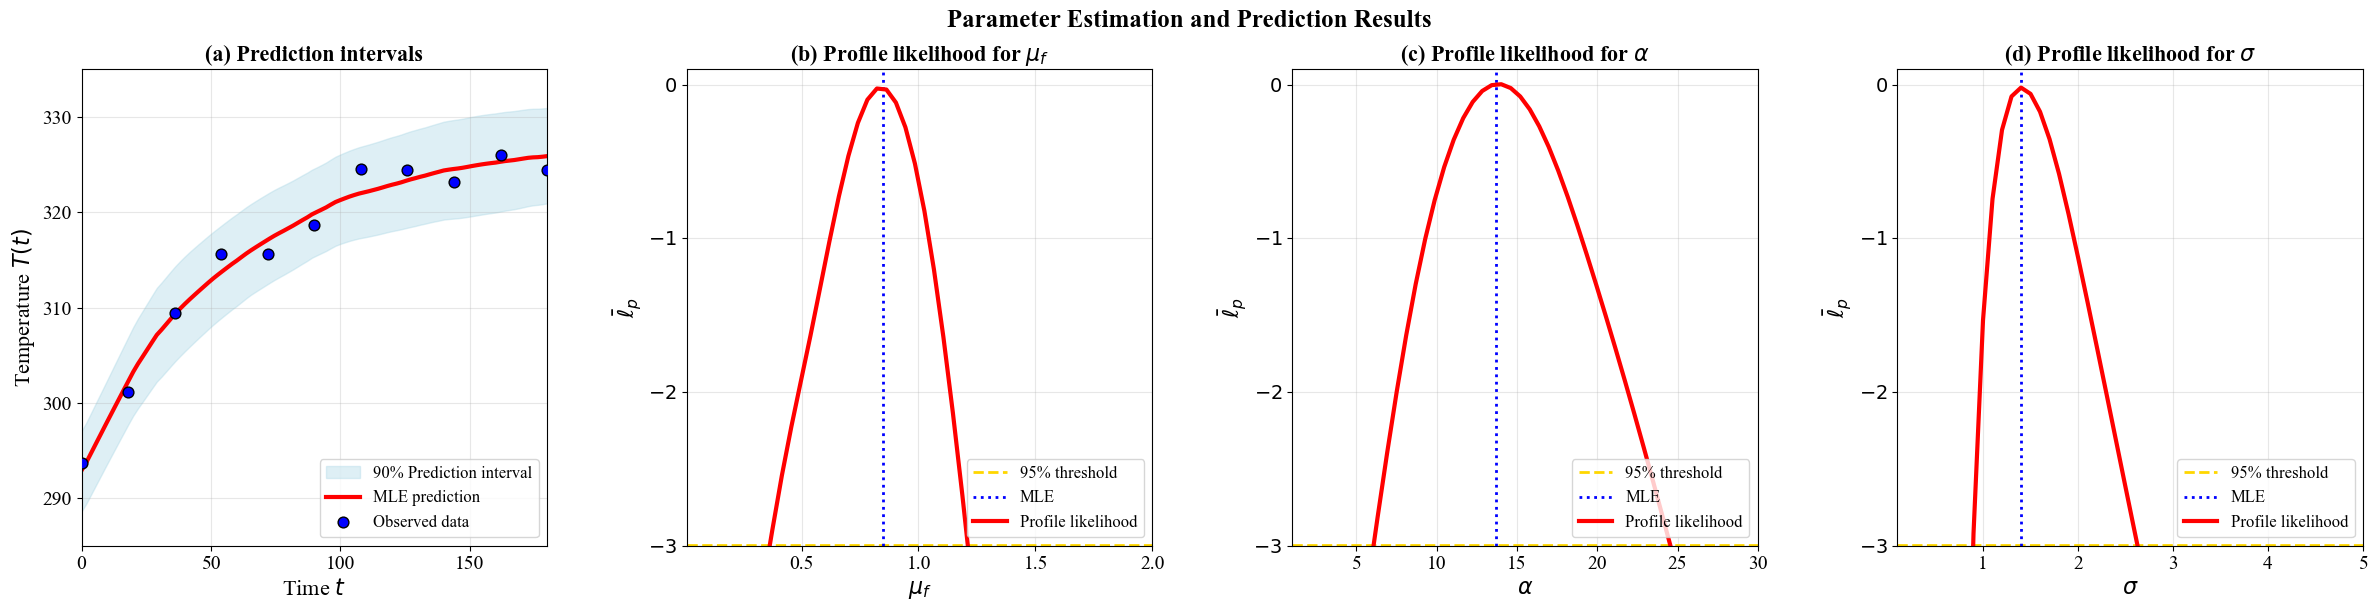

In [ ]:
# 3. 创建四合一综合图
fig_final, axes = plt.subplots(1, 4, figsize=(24, 6))

# 
ax_pred = axes[0]
ax_pred.fill_between(t_fine, lower_fine, upper_fine, color='lightblue', alpha=0.4, 
                    label='90% Prediction interval')
mle_prediction_fine = predictor.Tt([0.0858, mu2mle, alphamle], t_fine)
ax_pred.plot(t_fine, mle_prediction_fine, linewidth=3, color='red', 
            label='MLE prediction', linestyle='-')
ax_pred.scatter(t_obs, data, color='blue', s=60, zorder=5, 
               label='Observed data', edgecolors='black', linewidth=1)
ax_pred.set_xlabel(r"Time $t$", fontsize=16)
ax_pred.set_ylabel(r"Temperature $T(t)$", fontsize=16)
ax_pred.set_xlim(0, tmax)
ax_pred.set_ylim(285, 335)
ax_pred.legend(fontsize=12, frameon=True, loc='lower right')
ax_pred.tick_params(labelsize=14)
ax_pred.grid(True, alpha=0.3)
ax_pred.set_title(r"(a) Prediction intervals", fontsize=16, fontweight='bold')

# 
ax_mu2_final = axes[1]
ax_mu2_final.axhline(y=llstar, linewidth=2, color='gold', label='95% threshold', linestyle='--')
ax_mu2_final.axvline(x=mu2mle, linewidth=2, color='blue', label='MLE', linestyle=':')
sp3_mu2 = UnivariateSpline(mu2range, ff_mu2 - fmle, k=3, w=np.ones(len(mu2range)), s=1/100)
yy_mu2 = sp3_mu2(mu2range)
ax_mu2_final.plot(mu2range, yy_mu2, linewidth=3, color='red', label='Profile likelihood')
ax_mu2_final.set_ylim(-3, 0.1)
ax_mu2_final.set_xlim(mu2range[0], mu2range[-1])
ax_mu2_final.set_yticks([0, -1, -2, -3])
ax_mu2_final.set_yticklabels([r"$0$", r"$-1$", r"$-2$", r"$-3$"], fontsize=14)
ax_mu2_final.set_xlabel(r"$\mu_f$", fontsize=16)
ax_mu2_final.set_ylabel(r"$\bar{\ell}_p$", fontsize=16)
ax_mu2_final.legend(fontsize=12, frameon=True, loc='lower right')
ax_mu2_final.tick_params(labelsize=14)
ax_mu2_final.grid(True, alpha=0.3)
ax_mu2_final.set_title(r"(b) Profile likelihood for $\mu_f$", fontsize=16, fontweight='bold')

# 
ax_alpha_final = axes[2]
ax_alpha_final.axhline(y=llstar, linewidth=2, color='gold', label='95% threshold', linestyle='--')
ax_alpha_final.axvline(x=alphamle, linewidth=2, color='blue', label='MLE', linestyle=':')
sp3_alpha = UnivariateSpline(alpharange, ff_alpha - fmle, k=3, w=np.ones(len(alpharange)), s=1/100)
yy_alpha = sp3_alpha(alpharange)
ax_alpha_final.plot(alpharange, yy_alpha, linewidth=3, color='red', label='Profile likelihood')
ax_alpha_final.set_ylim(-3, 0.1)
ax_alpha_final.set_xlim(alpharange[0], alpharange[-1])
ax_alpha_final.set_yticks([0, -1, -2, -3])
ax_alpha_final.set_yticklabels([r"$0$", r"$-1$", r"$-2$", r"$-3$"], fontsize=14)
ax_alpha_final.set_xlabel(r"$\alpha$", fontsize=16)
ax_alpha_final.set_ylabel(r"$\bar{\ell}_p$", fontsize=16)
ax_alpha_final.legend(fontsize=12, frameon=True, loc='lower right')
ax_alpha_final.tick_params(labelsize=14)
ax_alpha_final.grid(True, alpha=0.3)
ax_alpha_final.set_title(r"(c) Profile likelihood for $\alpha$", fontsize=16, fontweight='bold')

# 
ax_sigma_final = axes[3]
ax_sigma_final.axhline(y=llstar, linewidth=2, color='gold', label='95% threshold', linestyle='--')
ax_sigma_final.axvline(x=sigmamle, linewidth=2, color='blue', label='MLE', linestyle=':')
sp3_sigma = UnivariateSpline(sigmarange, ff_sigma - fmle, k=3, w=np.ones(len(sigmarange)), s=1/100)
yy_sigma = sp3_sigma(sigmarange)
ax_sigma_final.plot(sigmarange, yy_sigma, linewidth=3, color='red', label='Profile likelihood')
ax_sigma_final.set_ylim(-3, 0.1)
ax_sigma_final.set_xlim(sigmarange[0], sigmarange[-1])
ax_sigma_final.set_yticks([0, -1, -2, -3])
ax_sigma_final.set_yticklabels([r"$0$", r"$-1$", r"$-2$", r"$-3$"], fontsize=14)
ax_sigma_final.set_xlabel(r"$\sigma$", fontsize=16)
ax_sigma_final.set_ylabel(r"$\bar{\ell}_p$", fontsize=16)
ax_sigma_final.legend(fontsize=12, frameon=True, loc='lower right')
ax_sigma_final.tick_params(labelsize=14)
ax_sigma_final.grid(True, alpha=0.3)
ax_sigma_final.set_title(r"(d) Profile likelihood for $\sigma$", fontsize=16, fontweight='bold')

# 
plt.tight_layout()
plt.subplots_adjust(wspace=0.3)

# 添加总标题
fig_final.suptitle('Parameter Estimation and Prediction Results', fontsize=18, fontweight='bold', y=1.02)

plt.show()

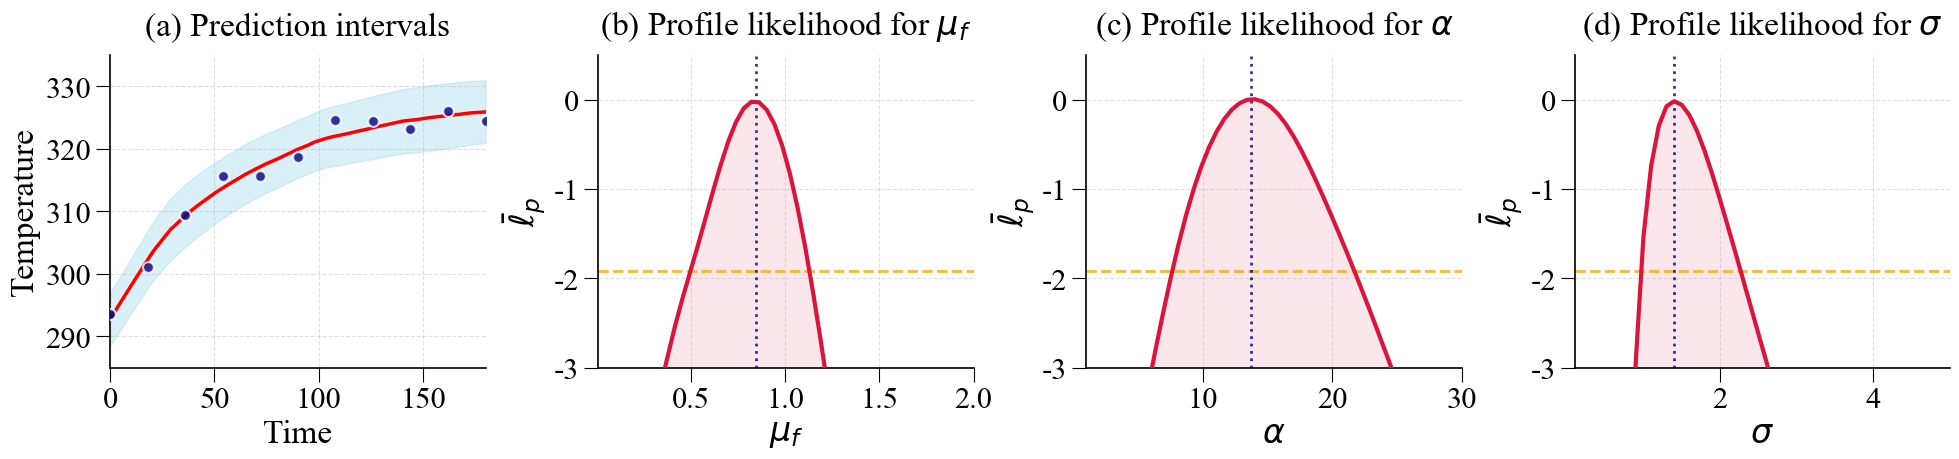

In [ ]:
# 
plt.rcParams.update({
    'font.family': 'Times New Roman',
    'font.size': 20,
    'axes.linewidth': 1.2,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'xtick.major.size': 10,
    'xtick.minor.size': 6,
    'ytick.major.size': 10,
    'ytick.minor.size': 6,
    'xtick.labelsize': 30,
    'ytick.labelsize': 30,
    'legend.framealpha': 0.9,
    'legend.fancybox': True,
    'grid.linewidth': 0.8,
    'lines.linewidth': 2.5,
})

# 
fig_publication, axes = plt.subplots(1, 4, figsize=(20, 5))

# 
ax1 = axes[0]
ax1.fill_between(t_fine, lower_fine, upper_fine, color='skyblue', alpha=0.3, 
                label='90% Prediction interval', zorder=1)
mle_curve = predictor.Tt([0.0858, mu2mle, alphamle], t_fine)
ax1.plot(t_fine, mle_curve, 'r-', linewidth=2.5, label='MLE prediction', zorder=3)
ax1.scatter(t_obs, data, color='navy', s=60, zorder=4, label='Observed data', 
           edgecolors='white', linewidth=1.5, alpha=0.8)
ax1.set_xlabel('Time', fontsize=24)
ax1.set_ylabel('Temperature', fontsize=24)
ax1.set_xlim(0, tmax)
ax1.set_ylim(285, 335)
ax1.tick_params(labelsize=22)
ax1.grid(True, alpha=0.4, linestyle='--')
ax1.set_title('(a) Prediction intervals', fontsize=24, pad=15)
llstar=-1.92

# 
ax2 = axes[1]
ax2.axhline(y=llstar, color='orange', linestyle='--', linewidth=2, label='95% threshold', alpha=0.8)
ax2.axvline(x=mu2mle, color='darkblue', linestyle=':', linewidth=2, label='MLE', alpha=0.8)
yy_mu2_pub = sp3_mu2(mu2range)  # 使用统一的剖面似然
ax2.plot(mu2range, yy_mu2_pub, 'crimson', linewidth=3, label='Profile likelihood', zorder=3)
ax2.fill_between(mu2range, yy_mu2_pub, -3, alpha=0.1, color='crimson')
ax2.set_ylim(-3, 0.5)
ax2.set_xlim(mu2min, mu2max)
ax2.set_xlabel(r'$\mu_f$', fontsize=24)
ax2.set_ylabel(r'$\bar{\ell}_p$', fontsize=24)
ax2.tick_params(labelsize=22)
ax2.grid(True, alpha=0.4, linestyle='--')
ax2.set_title(r'(b) Profile likelihood for $\mu_f$', fontsize=24, pad=15)

# 
ax3 = axes[2]
ax3.axhline(y=llstar, color='orange', linestyle='--', linewidth=2, label='95% threshold', alpha=0.8)
ax3.axvline(x=alphamle, color='darkblue', linestyle=':', linewidth=2, label='MLE', alpha=0.8)
yy_alpha_pub = sp3_alpha(alpharange)  # 使用统一的剖面似然
ax3.plot(alpharange, yy_alpha_pub, 'crimson', linewidth=3, label='Profile likelihood', zorder=3)
ax3.fill_between(alpharange, yy_alpha_pub, -3, alpha=0.1, color='crimson')
ax3.set_ylim(-3, 0.5)
ax3.set_xlim(alphamin, alphamax)
ax3.set_xlabel(r'$\alpha$', fontsize=24)
ax3.set_ylabel(r'$\bar{\ell}_p$', fontsize=24)
ax3.tick_params(labelsize=22)
ax3.grid(True, alpha=0.4, linestyle='--')
ax3.set_title(r'(c) Profile likelihood for $\alpha$', fontsize=24, pad=15)

# 
ax4 = axes[3]
ax4.axhline(y=llstar, color='orange', linestyle='--', linewidth=2, label='95% threshold', alpha=0.8)
ax4.axvline(x=sigmamle, color='darkblue', linestyle=':', linewidth=2, label='MLE', alpha=0.8)
yy_sigma_pub = sp3_sigma(sigmarange)  # 使用统一的剖面似然
ax4.plot(sigmarange, yy_sigma_pub, 'crimson', linewidth=3, label='Profile likelihood', zorder=3)
ax4.fill_between(sigmarange, yy_sigma_pub, -3, alpha=0.1, color='crimson')
ax4.set_ylim(-3, 0.5)
ax4.set_xlim(sigmamin, sigmamax)
ax4.set_xlabel(r'$\sigma$', fontsize=24)
ax4.set_ylabel(r'$\bar{\ell}_p$', fontsize=24)
ax4.tick_params(labelsize=22)
ax4.grid(True, alpha=0.4, linestyle='--')
ax4.set_title(r'(d) Profile likelihood for $\sigma$', fontsize=24, pad=15)

# 调整布局
plt.tight_layout()
plt.subplots_adjust(wspace=0.3)


plt.show()